In [1]:
import os
import pandas as pd
import numpy as np
import json
import pickle
from collections import defaultdict
from pathlib import Path
from statistics import mean, stdev
from sklearn.metrics import ndcg_score, dcg_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import os, sys
parentPath = os.path.abspath("..")
if parentPath not in sys.path:
    sys.path.insert(0, parentPath)
    
from src.data import load_source
from src.config import Config, get_option_fallback
from src.path import get_best_model_paths, get_exp_paths, get_report_path, load_json, load_rep_cfg, get_exp_names
from src.trainer import Trainer

In [2]:
# projectdir = Path('/code')
projectdir = Path('..')
assert projectdir.exists()

# Common Functions

In [4]:
def summarize_test_res(rep, folds=5):
    print(rep['config']['exp_name'], end=':\t')
    s = pd.Series([rep['best']['auc_epoch'][str(i)] for i in range(folds)])
    print(f'Best epoch at {s.mean():>6.1f}±{s.std():<5.1f}', end='\t')
    s = pd.Series([rep['best']['auc'][str(i)] for i in range(folds)])
    print(f'Valid AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = pd.Series([rep['indicator']['test_auc'][str(i)][0] for i in range(folds)])
    print(f'Test AUC: {s.mean()*100:.4f}±{s.std()*100:.4f}', end='\t')
    s = rep['indicator']['RPsoft']['all']
    print(f'Good:Bad = {s["good"]}:{s["bad"]}', end='\t')
    s = rep['indicator']['test_auc']['all'][0]
    print(f'All Test AUC: {s*100:.4f}')

In [5]:
def show_valid_lc(name, idclist_dic, idc='eval_auc'):
    min_len = min([len(_x) for _x in idclist_dic['epoch'].values()])
    x = idclist_dic['epoch']['0'][:min_len] * (len(idclist_dic['epoch']) -1)  # exclude 'all'
    y = []
    for _y in idclist_dic[idc].values():
        y += _y[:min_len]
    sns.lineplot(x=x, y=y, label=name)
    plt.title(idc)

## Learning curve

In [7]:
def lc(config_name, objective='eval_auc', kfold=5, legend=False):
    # exp_names = ['ksvector_l10.auto', 'ksvector_l10.02.auto', 'ksvector_l150.auto']
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    fig, ax = plt.subplots()
    for r in reports:
        x = []
        y = []
#         print(r['indicator']['epoch'])
        for k in range(kfold):
            x += r['indicator']['epoch'][str(k)]
            y += r['indicator'][objective][str(k)]
        # print(len(x), len(y))
        sns.lineplot(x, y, label=r['config']['exp_name'] if legend else '', ax=ax)
    if legend:
        ax.legend()

['pre_dummy_epoch_size0.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size100.auto']


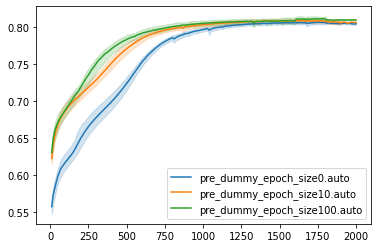

In [9]:
lc('20_0818_ieeeBD2020_assist09_pre', legend=True)

## NDCG

In [8]:
from statistics import stdev

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto', 'sequence_size200.auto']
[80, 90, 80, 90, 80]
[110, 110, 100, 100, 100]
[130, 120, 120, 130, 130]
[150, 150, 160, 180, 160]
[200, 180, 180, 170, 180]
[210, 190, 180, 180, 190]


,name,good,bad,r1,r2,r2_std,auc,auc_c,best_epoch
0,sequence_size10.auto,91.6,18.4,0.832727,0.886511,0.130176,0.797171,NaN,654
1,sequence_size20.auto,91.2,18.8,0.829091,0.877309,0.130399,0.801023,NaN,846
2,sequence_size30.auto,87.8,22.2,0.798182,0.856329,0.131783,0.800012,NaN,1066
3,sequence_size40.auto,87.4,22.6,0.794545,0.857940,0.128433,0.803384,NaN,1392
4,sequence_size50.auto,85.2,24.8,0.774545,0.850559,0.125235,0.802260,NaN,1630
5,sequence_size200.auto,89.6,20.4,0.814545,0.855410,0.094750,0.808092,NaN,1690


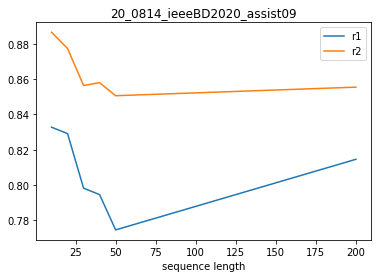

In [94]:
def ndcg(config_name, objective='eval_auc', kfold=5, legend=False):
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    res = pd.DataFrame(columns=['name', 'good','bad','r1', 'r2','r2_std', 'auc','auc_c','best_epoch'])
    for r in reports:
        good = []
        bad = []
        ndcg = []
        ndcg_std = []
        auc = []
        auc_c = []
        epoch = []
        for k in range(kfold):
            good.append(r['indicator']['RPsoft'][str(k)]['good'])
            bad.append(r['indicator']['RPsoft'][str(k)]['bad'])
            ndcg.append(mean(r['indicator']['RPhard'][str(k)]))
            ndcg_std.append(stdev(r['indicator']['RPhard'][str(k)]))
            auc.append(r['best']['auc'][str(k)])
            auc_c.append(r['indicator']['eval_auc_c'][str(k)])
#             print((r['indicator']['eval_auc_c'][str(k)]))
            epoch.append(r['best']['auc_epoch'][str(k)])
        row = {
            'name': r['config']['exp_name'], 
            'good': mean(good), 
            'bad': mean(bad), 
            'r1': mean(good) / (110),
            'r2': mean(ndcg), 
            'r2_std': mean(ndcg_std), 
            'auc': mean(auc), 
#             'auc_c': mean(auc_c), 
            'best_epoch': mean(epoch)
        }
        print([len(c) for c in auc_c])
        res = res.append(row, ignore_index=True)
    fig, ax = plt.subplots()
    xidx = [10,20,30,40,50,200]
    sns.lineplot(xidx, list(res['r1']), label='r1', ax=ax)
    sns.lineplot(xidx, list(res['r2']), label='r2', ax=ax)
    plt.xlabel('sequence length')
    plt.title(config_name)
    
    return res
    
    
        
#         sns.lineplot(x, y, label=r['config']['exp_name'] if legend else '', ax=ax)
#     if legend:
#         ax.legend()

normal = ndcg('20_0814_ieeeBD2020_assist09')
normal

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
                   name   good  bad        r1        r2    r2_std       auc  \
0  sequence_size10.auto  103.8  6.2  0.943636  0.924532  0.101760  0.798963   
1  sequence_size20.auto  105.6  4.4  0.960000  0.908703  0.106116  0.803309   
2  sequence_size30.auto  104.4  5.6  0.949091  0.892798  0.113109  0.803227   
3  sequence_size40.auto  105.4  4.6  0.958182  0.885496  0.110165  0.806216   
4  sequence_size50.auto  105.4  4.6  0.958182  0.892444  0.112369  0.805652   

  best_epoch  
0        620  
1        796  
2       1028  
3       1320  
4       1574  


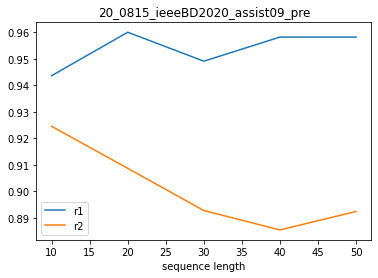

In [47]:
withpre = ndcg('20_0815_ieeeBD2020_assist09_pre')

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
                   name  good   bad        r1        r2    r2_std       auc  \
0  sequence_size10.auto  92.8  17.2  0.843636  0.899168  0.122369  0.797817   
1  sequence_size20.auto  91.6  18.4  0.832727  0.886565  0.127185  0.801181   
2  sequence_size30.auto  91.4  18.6  0.830909  0.869362  0.127275  0.798603   
3  sequence_size40.auto  89.6  20.4  0.814545  0.864340  0.125875  0.800859   
4  sequence_size50.auto  88.2  21.8  0.801818  0.852057  0.122499  0.798785   

  best_epoch  
0        820  
1        956  
2       1062  
3       1412  
4       1652  


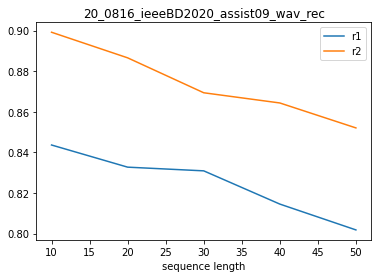

In [10]:
withpre = ndcg('20_0816_ieeeBD2020_assist09_wav_rec')

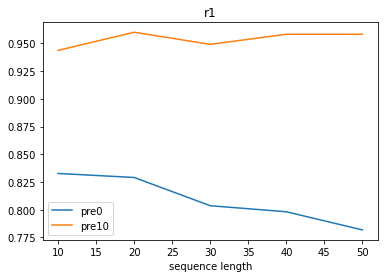

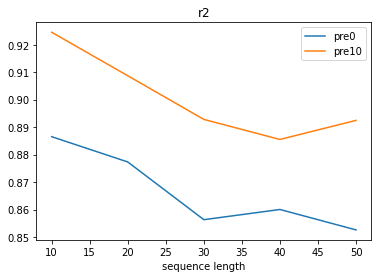

In [49]:
normal
withpre

def compare_two(a, b, col_name, a_label='pre0', b_label='pre10'):
    fig, ax = plt.subplots()
    sns.lineplot(list(range(10,51,10)), list(a[col_name]), label=a_label, ax=ax)
    sns.lineplot(list(range(10,51,10)), list(b[col_name]), label=b_label, ax=ax)
    plt.xlabel('sequence length')
    plt.title(col_name)

compare_two(normal, withpre, 'r1')
compare_two(normal, withpre, 'r2')

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto', 'sequence_size200.auto']
['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto', 'sequence_size200.auto']
['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']


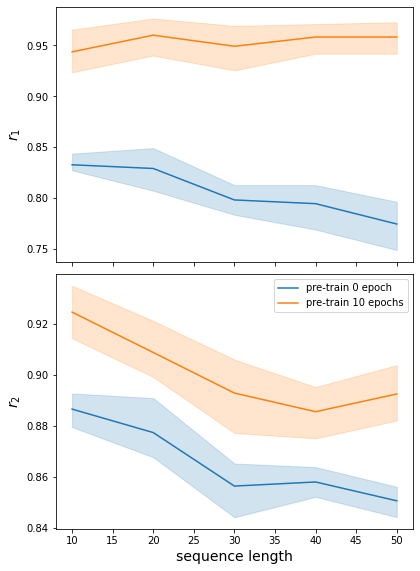

In [19]:
def ndcg_plot_with_std(config_name, ax, objective='eval_auc', kfold=5, yname=('RPhard','$r_2$'), label=''):
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    
    r2 = []
    r2_std = []
    xs = []
    for r in reports:
        seq_size = r['config']['sequence_size']
        if seq_size == 200:
            continue
            
        for k in range(kfold):
            # xs += [seq_size]*110
            # ndcg += r['indicator'][yname[0]][str(k)]
            xs += [seq_size]
            r2 += [mean(r['indicator'][yname[0]][str(k)])]
    # sns.lineplot(xs, ndcg, label=label, ax=ax)
    sns.lineplot(xs, r2, label=label, ax=ax)

    
def r1_plot_with_std(config_name, ax, objective='eval_auc', kfold=5, yname=('RPsoft','$r_1$'), label=''):
    report_paths = [get_report_path(projectdir, config_name, e) for e in get_exp_names(projectdir, config_name)]
    reports = [load_json(r) for r in report_paths]
    
    r1 = []
    xs = []
    for r in reports:
        seq_size = r['config']['sequence_size']
        if seq_size == 200:
            continue
            
        for k in range(kfold):
            # xs += [seq_size]*110
            # ndcg += r['indicator'][yname[0]][str(k)]
            xs += [seq_size]
            soft = r['indicator']['RPsoft'][str(k)]
            r1 += [soft['good'] / (soft['good']+soft['bad'])]
    # sns.lineplot(xs, ndcg, label=label, ax=ax)
    sns.lineplot(xs, r1, label=label, ax=ax)
    

fig, axs = plt.subplots(2, sharex=True, figsize=(6.4, 4.8 * 2))
fig.subplots_adjust(hspace=.05, wspace=.16)

r1_plot_with_std('20_0814_ieeeBD2020_assist09', axs[0], label='pre 0')
r1_plot_with_std('20_0815_ieeeBD2020_assist09_pre', axs[0], label='pre 10')
axs[0].set_ylabel('$r_1$')
axs[0].yaxis.label.set_fontsize(14)
axs[0].legend()
axs[0].get_legend().remove()

ndcg_plot_with_std('20_0814_ieeeBD2020_assist09', axs[1], label='pre-train 0 epoch')
ndcg_plot_with_std('20_0815_ieeeBD2020_assist09_pre', axs[1], label='pre-train 10 epochs')
axs[1].set_xlabel('sequence length')
axs[1].set_ylabel('$r_2$')
axs[1].xaxis.label.set_fontsize(14)
axs[1].yaxis.label.set_fontsize(14)
axs[1].legend()

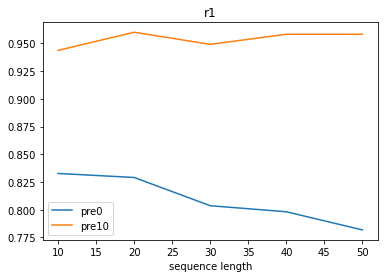

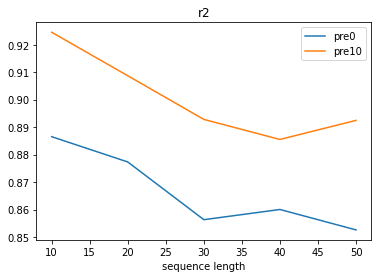

In [49]:
normal
withpre

fig, ax = plt.subplots()
col_name = 'r2'
sns.lineplot(list(range(10,51,10)), list(a[col_name]), label='pre0', ax=ax)
sns.lineplot(list(range(10,51,10)), list(b[col_name]), label='pre10', ax=ax)
plt.xlabel('sequence length')
plt.title(col_name)

compare_two(normal, withpre, 'r1')
compare_two(normal, withpre, 'r2')

## Waviness, Reconstruction

### Pre0

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
420 420
520 520
630 630
780 780
910 910


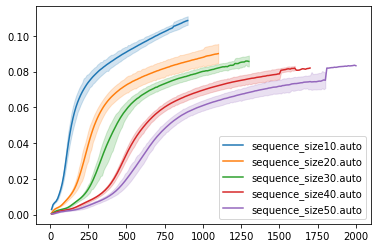

In [54]:
lc('20_0814_ieeeBD2020_assist09', 'waviness_l1', legend=True)

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
420 420
520 520
630 630
780 780
910 910


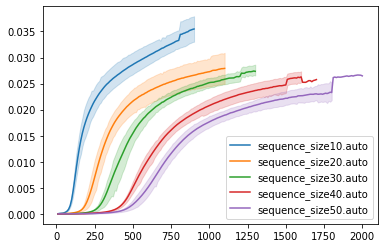

In [55]:
lc('20_0814_ieeeBD2020_assist09', 'waviness_l2', legend=True)

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']


KeyError: 'reconstruction_loss'

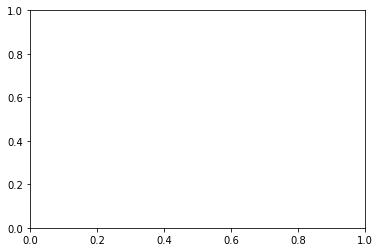

In [57]:
lc('20_0814_ieeeBD2020_assist09', 'reconstruction_loss', legend=True)

### Pre10

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
420 420
490 490
620 620
760 760
890 890


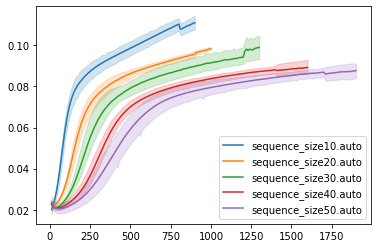

In [51]:
lc('20_0815_ieeeBD2020_assist09_pre', 'waviness_l1', legend=True)

['sequence_size10.auto', 'sequence_size20.auto', 'sequence_size30.auto', 'sequence_size40.auto', 'sequence_size50.auto']
420 420
490 490
620 620
760 760
890 890


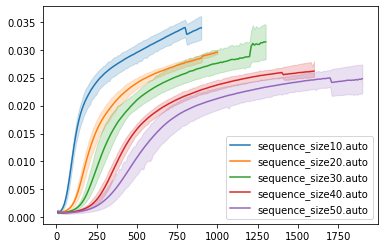

In [52]:
lc('20_0815_ieeeBD2020_assist09_pre', 'waviness_l2', legend=True)

## Single Invert Performance

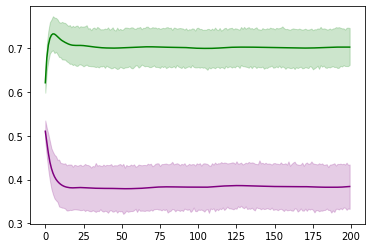

In [24]:
def invert_performance(report_path):
    report = load_json(report_path)
    cor = report['indicator']['inverted_performance_cor']['all']
    wro = report['indicator']['inverted_performance_wro']['all']
    xidx = list(range(len(cor[0])))
    xs = xidx * len(cor)
    sns.lineplot(xs, [y for yl in cor for y in yl], color='green')
    sns.lineplot(xs, [y for yl in wro for y in yl], color='purple')
    
invert_performance('../output/20_0814_ieeeBD2020_assist09/sequence_size200.auto/report/20200818-1833/report.json')

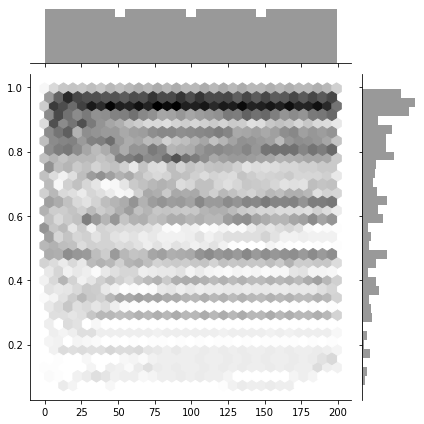

In [39]:
def invert_performance(report_path):
    report = load_json(report_path)
    cor = report['indicator']['inverted_performance_cor']['all']
#     wro = report['indicator']['inverted_performance_wro']['all']
    xidx = list(range(len(cor[0])))
    xs = xidx * len(cor)
    sns.jointplot(xs, [y for yl in cor for y in yl],kind="hex", color="k")
#     sns.lineplot(xs, [y for yl in wro for y in yl])
    
invert_performance('../output/20_0814_ieeeBD2020_assist09/sequence_size200.auto/report/20200818-1833/report.json')

In [52]:
from sklearn.metrics import ndcg_score

['pre_dummy_epoch_size0.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size100.auto']


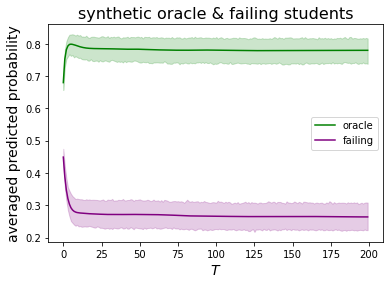

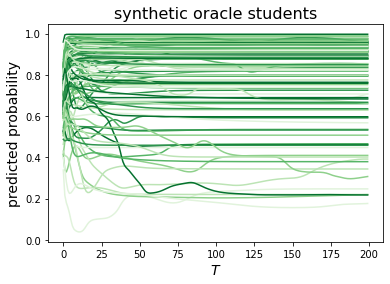

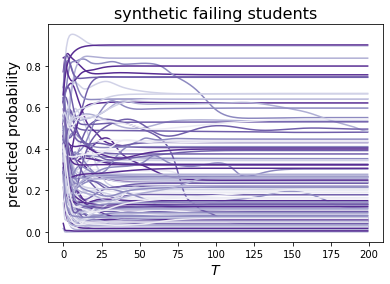

In [61]:
def get_reports(report_path_or_config_name):
    if Path(report_path_or_config_name).exists():
        reports = [load_json(report_path_or_config_name)]
    else:
        reports = []
        for e in get_exp_names(projectdir, report_path_or_config_name):
            try:
                reports.append(load_json(get_report_path(projectdir, report_path_or_config_name, e)))
            except:
                print(f'report for {e} not found.')
    return reports


max_len = 200
def invert_performance(report_path_or_config_name):
    reports = get_reports(report_path_or_config_name)
    for report in reports:
        if report['config']['exp_name'] != 'pre_dummy_epoch_size10.auto':
            continue
        cor = report['indicator']['inverted_performance_cor']['all']
        wro = report['indicator']['inverted_performance_wro']['all']
        xidx = list(range(len(cor[0])))[:max_len]
        xs = xidx * len(cor)
        sns.lineplot(xs, [y for yl in [s[:max_len] for s in cor] for y in yl], label='oracle', color='green')
        sns.lineplot(xs, [y for yl in [s[:max_len] for s in wro] for y in yl], label='failing', color='purple')
        plt.legend()
        plt.title('synthetic oracle & failing students', fontsize=16)
        plt.xlabel('$T$', fontsize=14)
        plt.ylabel('averaged predicted probability', fontsize=14)
        plt.show()
        
        sns.set_palette("Greens")
        for ys in sorted(cor, key=lambda x: ndcg_score([range(len(x))[::-1]], [x])):
            sns.lineplot(xidx, ys[:max_len])
        plt.title('synthetic oracle students', fontsize=16)
        plt.xlabel('$T$', fontsize=14)
        plt.ylabel('predicted probability', fontsize=14)
        plt.show()
        
        sns.set_palette("Purples")
        for ys in sorted(wro, key=lambda x: ndcg_score([range(len(x))[::1]], [x])):
            sns.lineplot(xidx, ys[:max_len])
        plt.title('synthetic failing students', fontsize=16)
        plt.xlabel('$T$', fontsize=14)
        plt.ylabel('predicted probability', fontsize=14)
        plt.show()
            
invert_performance('20_0818_ieeeBD2020_assist09_pre')

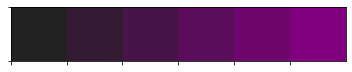

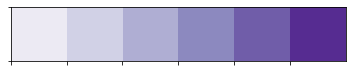

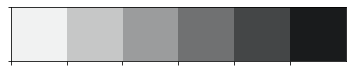

In [50]:
sns.palplot(sns.dark_palette("purple"))
plt.show()
sns.palplot(sns.color_palette("Purples"))
plt.show()
sns.palplot(sns.light_palette((210, 10, 10), input="husl"))

['pre_dummy_epoch_size0.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size100.auto']


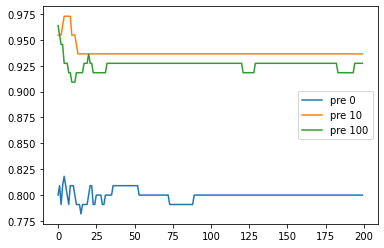

In [81]:
def invert_performance(report_path_or_config_name):
    if Path(report_path_or_config_name).exists():
        reports = [load_json(report_path_or_config_name)]
    else:
        reports = []
        for e in get_exp_names(projectdir, report_path_or_config_name):
            try:
                reports.append(load_json(get_report_path(projectdir, report_path_or_config_name, e)))
            except:
                print(f'report for {e} not found.')
    for report in reports:
        cor = report['indicator']['inverted_performance_cor']['all']
        wro = report['indicator']['inverted_performance_wro']['all']
        seq_size = len(cor[0])
        q_size = len(cor)
        xs = []
        r1 = []
        for i in range(seq_size):
            gb = [0, 0]
            for q in range(q_size):
                gb[cor[q][i] > wro[q][i]] += 1
            xs.append(i)
            r1.append(gb[1] / sum(gb))
        label = 'pre ' + str(report['config']['pre_dummy_epoch_size'])
        sns.lineplot(xs, r1, label=label)
invert_performance('20_0818_ieeeBD2020_assist09_pre')

In [82]:
from sklearn.metrics import ndcg_score

['pre_dummy_epoch_size0.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size100.auto']


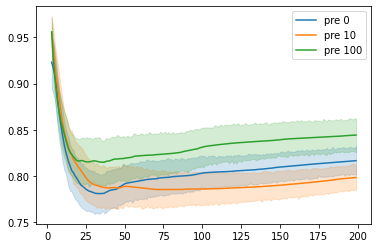

In [92]:
def invert_performance(report_path_or_config_name):
    if Path(report_path_or_config_name).exists():
        reports = [load_json(report_path_or_config_name)]
    else:
        reports = []
        for e in get_exp_names(projectdir, report_path_or_config_name):
            try:
                reports.append(load_json(get_report_path(projectdir, report_path_or_config_name, e)))
            except:
                print(f'report for {e} not found.')
    for report in reports:
        cor = report['indicator']['inverted_performance_cor']['all']
        wro = report['indicator']['inverted_performance_wro']['all']
        seq_size = len(cor[0])
        q_size = len(cor)
        xs = []
        r2 = []
        for i in range(3, seq_size):
            for q in range(q_size):
                xs.append(i)
                _score = ndcg_score(np.asarray([list(range(i))]), np.asarray([cor[q][:i]]))
                r2.append(_score)
        label = 'pre ' + str(report['config']['pre_dummy_epoch_size'])
        sns.lineplot(xs, r2, label=label)
invert_performance('20_0818_ieeeBD2020_assist09_pre')

['pre_dummy_epoch_size0.auto', 'pre_dummy_epoch_size10.auto', 'pre_dummy_epoch_size100.auto']


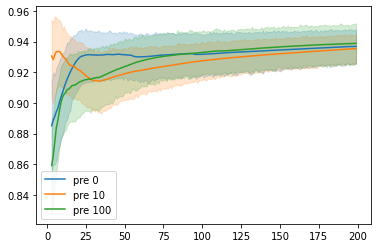

In [97]:
def invert_performance(report_path_or_config_name):
    if Path(report_path_or_config_name).exists():
        reports = [load_json(report_path_or_config_name)]
    else:
        reports = []
        for e in get_exp_names(projectdir, report_path_or_config_name):
            try:
                reports.append(load_json(get_report_path(projectdir, report_path_or_config_name, e)))
            except:
                print(f'report for {e} not found.')
    for report in reports:
        cor = report['indicator']['inverted_performance_cor']['all']
        wro = report['indicator']['inverted_performance_wro']['all']
        seq_size = len(cor[0])
        q_size = len(cor)
        xs = []
        r2 = []
        for i in range(3, seq_size):
            for q in range(q_size):
                xs.append(i)
                _score = ndcg_score(np.asarray([range(i)[::-1]]), np.asarray([wro[q][:i]]))
                r2.append(_score)
        label = 'pre ' + str(report['config']['pre_dummy_epoch_size'])
        sns.lineplot(xs, r2, label=label)
invert_performance('20_0818_ieeeBD2020_assist09_pre')